In [1]:
import xarray as xr
import geopandas as gpd
import rootutils
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
notebook_root = Path().resolve()
home_folder = rootutils.setup_root(str(notebook_root), indicator=".project-root", pythonpath=True)
from src.utils.visualizations import contrast_stretch_xr
from src.datasets.utils import resample

In [2]:
geoid = '21239'
pid = '1'
data_folder = f"{home_folder}/data/CropClimateX"

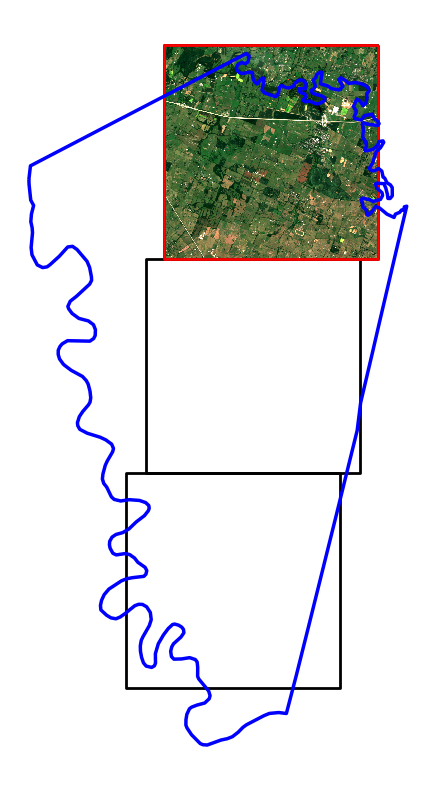

In [3]:
# create a sample figure with the shape from the county and the minicubes + sentinel2 data
modal = 'sen2'

gdf = gpd.read_file(f"{data_folder}/minicubes_geometry/minicubes_{geoid}.geojson")
shp = gpd.read_file(f"{data_folder}/county_list.geojson")
shp = shp[shp['GEOID'] == geoid]
shp = shp.to_crs(gdf.crs)
ds = xr.open_zarr(f"{data_folder}/{modal}/{modal}_{geoid}_0-9.zarr", group=pid)
ds_b = contrast_stretch_xr(ds[['B04', 'B03', 'B02']].isel(time=40).to_array().clip(0.1, 0.4))

fig,ax = plt.subplots(figsize=(10,10))
ds_b.plot.imshow(ax=ax, zorder=1)
gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)
gdf = gdf[gdf['GEOID_PID'] == f"{geoid}_{pid}"]
gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
shp.plot(ax=ax, facecolor='none', edgecolor='blue', alpha=1, linewidth=2.5,clip_on=False)

ax.set_aspect('equal')
ax.axis('off')
ax.set_title('')

fig.show()

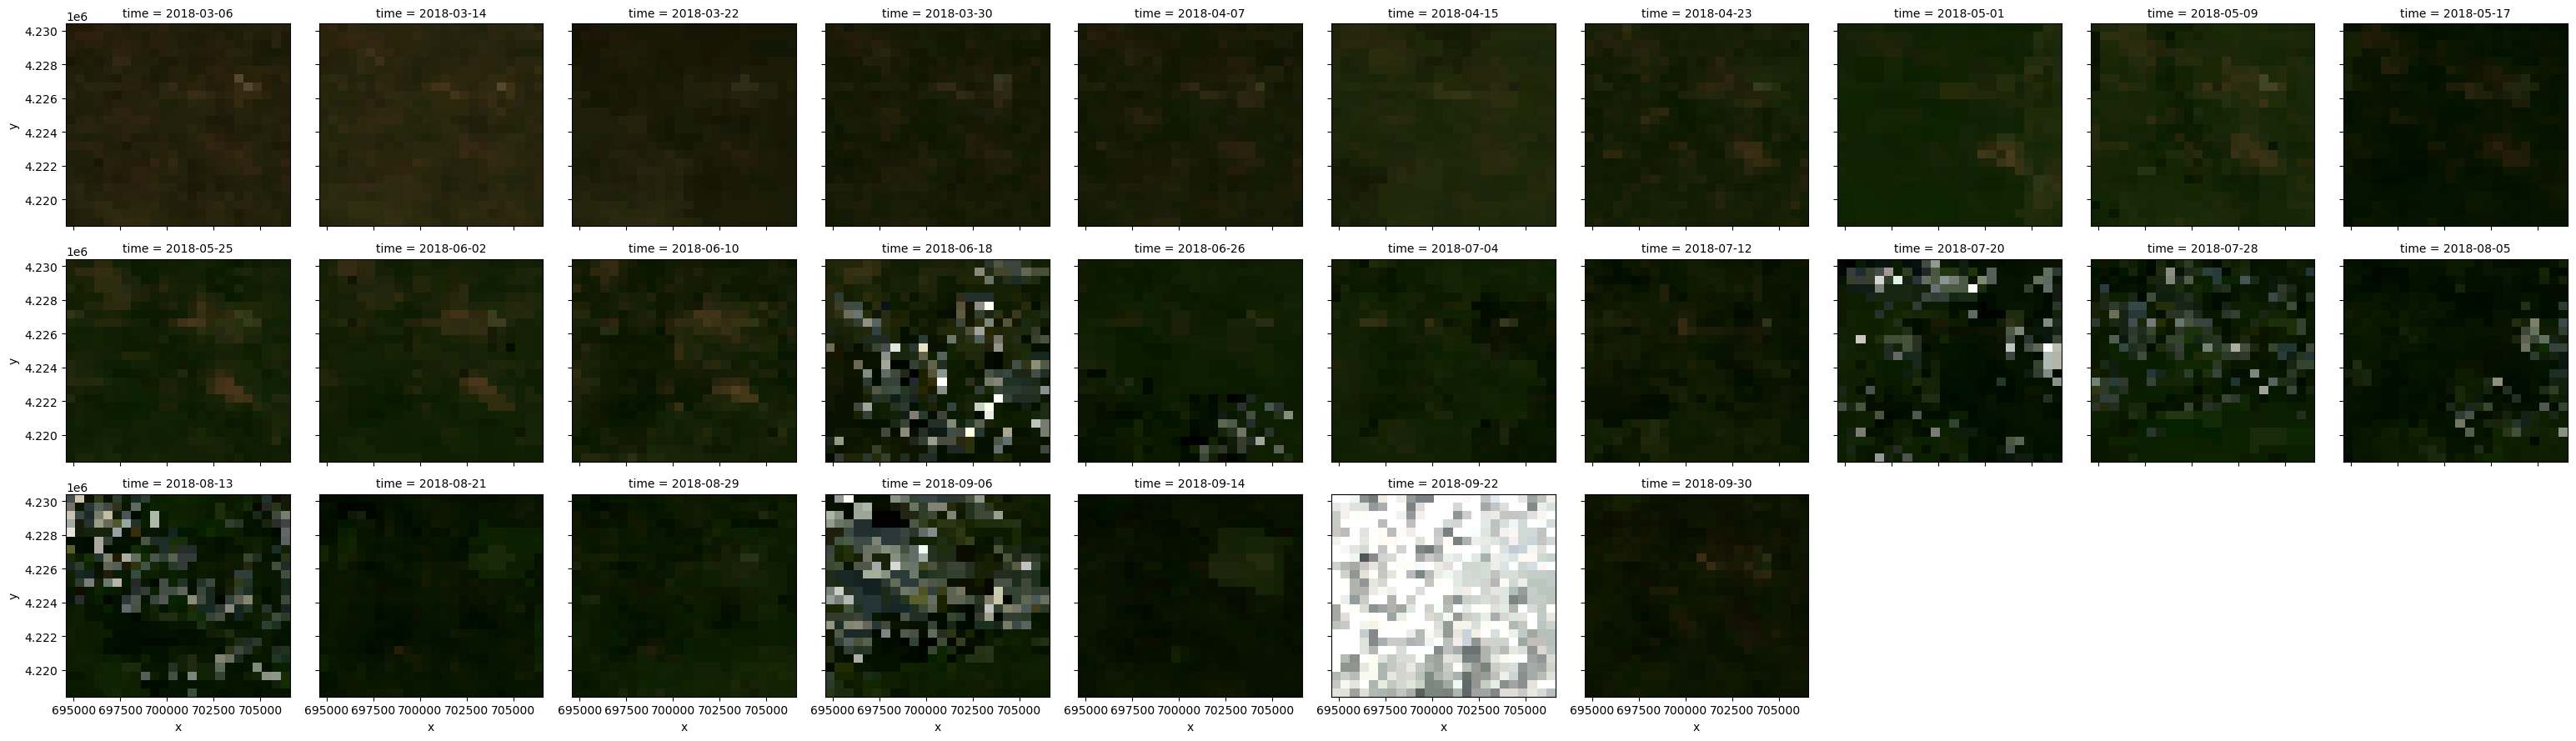

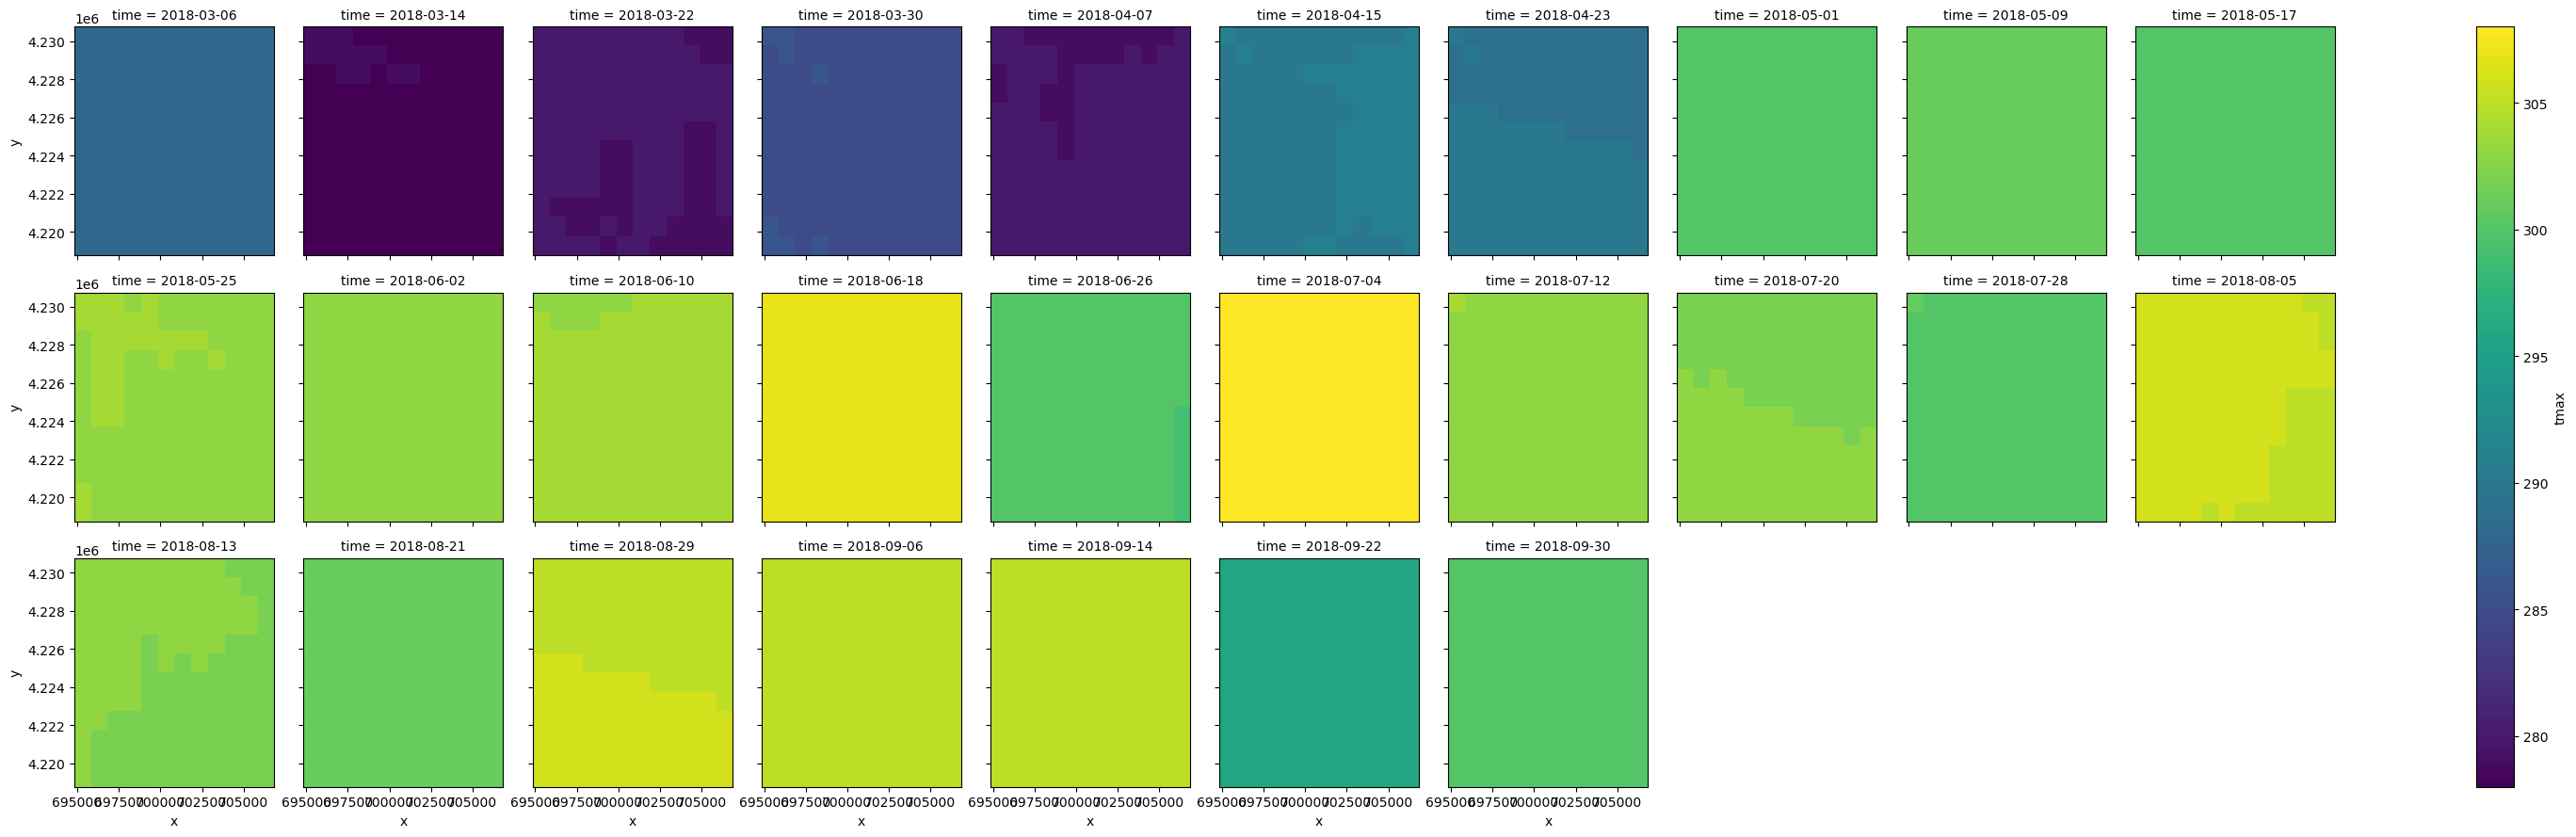

In [4]:
# plot a sample time series of modis data and resampled daymet data
modal = 'modis'
ds = xr.open_zarr(f"{data_folder}/{modal}/{modal}_{geoid}_0-9.zarr", group=pid)
# take RGB bands
ds = ds[['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03']]
# select the first year
ds = ds.sel(time=slice('2018-03-01', '2018-09-30')).to_array()
ds = ds.clip(0., .5)
ds = contrast_stretch_xr(ds)

modal = 'daymet'
ds_daymet = xr.open_zarr(f"{data_folder}/{modal}/{modal}_{geoid}_0-9.zarr", group=pid)
# select the first year
ds_daymet = ds_daymet.sel(time=slice('2018-03-01', '2018-09-30'))
# ds_daymet = ds_daymet.sel(time=slice('2018-01-01', '2018-01-02'))
ds_daymet = ds_daymet['tmax']
# resample to modis time resolution
res_dict = {
    "temporal": {'method': 'linear/mean', 'size': 'master'}
}
ds_daymet = resample(ds_daymet, res_dict, master=ds)

# plot it
ds.plot.imshow(col='time', col_wrap=10)
ds_daymet.plot.imshow(col='time', col_wrap=10)